In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
t = transforms.Compose([transforms.ToTensor(),
                       transforms.Lambda(lambda x : x.permute(1, 2, 0).reshape(-1))
                       ])
target_t = lambda label: F.one_hot(torch.tensor(label), num_classes=10)


train_dataset = datasets.SVHN(root="./data", split="train", transform= t, target_transform=target_t, download=True)
test_dataset = datasets.SVHN(root="./data", split="test", transform= t, target_transform=target_t, download=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [3]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


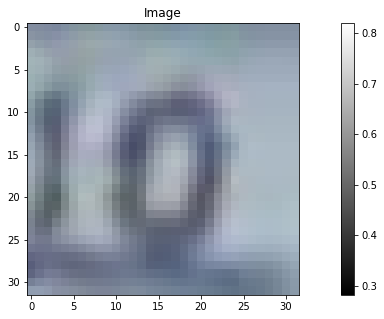

In [4]:
# print(next(iter(test_loader)))
img = next(iter(test_loader))[0][3].reshape(32,32,3)
label = next(iter(test_loader))[1][3]
def visual(img):    
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    img = img.numpy()
    im = ax.imshow(img, cmap=plt.cm.gray)
    fig.colorbar(im)
    ax.set_title("Image")

visual(img)
print(label)

In [5]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dims = 3072
        self.layer1 = nn.Linear(in_features=3072, out_features=512)
        self.layer2 = nn.Linear(in_features=512, out_features=256)
        self.layer3 = nn.Linear(in_features=256, out_features=64)
        self.layer4 = nn.Linear(in_features=64, out_features=10)
        
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.relu3 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        x = self.layer4(x)
        pred = F.log_softmax(x, dim=1)
        return x

In [26]:
device = "cuda"
model = Network()
model.to(device)
criterion = nn.CrossEntropyLoss().to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [27]:
def training(Epochs=20):
    loss_list= []
    loss_hist  = []
    for epoch in range(Epochs):
        cur_loss_list = []
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (img, label) in progress_bar:
            img, label = img.to(device), label.type(torch.float32).to(device)

            pred = model.forward(img)

            loss = criterion(pred, label)
            cur_loss_list.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if(i % 1 == 0):
                progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
        loss_list = loss_list + cur_loss_list        
        loss_hist.append(np.mean(cur_loss_list))
    return loss_list, loss_hist

In [28]:
training()

Epoch 20 Iter 287: loss 0.80323. : 100%|██████| 287/287 [00:09<00:00, 28.88it/s]


([2.2927706241607666,
  2.3149032592773438,
  2.2457168102264404,
  2.2863216400146484,
  2.2749671936035156,
  2.24428129196167,
  2.2393441200256348,
  2.2332682609558105,
  2.2266030311584473,
  2.246453046798706,
  2.2450950145721436,
  2.204850673675537,
  2.242601156234741,
  2.247096538543701,
  2.24265193939209,
  2.263230323791504,
  2.2441494464874268,
  2.230520248413086,
  2.244115114212036,
  2.243669033050537,
  2.232872724533081,
  2.2711849212646484,
  2.24069881439209,
  2.2747273445129395,
  2.2118020057678223,
  2.258277416229248,
  2.238563060760498,
  2.2483694553375244,
  2.225809335708618,
  2.219372034072876,
  2.2358739376068115,
  2.279771566390991,
  2.2545838356018066,
  2.27726411819458,
  2.2497453689575195,
  2.267886161804199,
  2.2535464763641357,
  2.252537727355957,
  2.2545394897460938,
  2.262732982635498,
  2.228445529937744,
  2.2288002967834473,
  2.228731155395508,
  2.225325107574463,
  2.2604360580444336,
  2.246239185333252,
  2.2400474548339

In [29]:
def testing(test_loader, net):
    with torch.no_grad():
        total_corr = 0
        for x, y in test_loader:
#             x, y = x.to(device), y.type(torch.float32).to(device)

            output = net.forward(x)

            pred = torch.argmax(torch.Tensor(output), dim=1)
            gt = torch.argmax(y, dim=1)
            correct = torch.count_nonzero(pred == gt)
            total_corr += correct
        return (total_corr/len(test_dataset))

In [30]:
testing(test_loader, model.to("cpu"))

tensor(0.7315)